In [1]:
import os
import firebase_admin
import time
from tqdm.auto import tqdm
from firebase_admin import credentials, firestore

if '.gitignore' not in os.listdir():
    os.chdir('..')

/Users/lioneljeanrenaud/.pyenv/versions/3.9.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Analysing movies from offline-database (in 2022)

In [41]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import os

def plot_decades(decades_played, setxticks=False, cast_int=True):
    plt.clf()
    plt.figure(figsize=(12, 6), dpi=80)
    _ = plt.gca()
    if cast_int:
        plt.bar(decades_played[:,0].astype(int), decades_played[:,1].astype(int), width=2.5)
    else:
        plt.bar(decades_played[:,0], decades_played[:,1].astype(int), width=2.5)
    
    if setxticks:
        _, _ = plt.xticks(decades_played[:,0].astype(int))
    plt.show()

def get_counters_movies_and_dates(data_per_date, movie_info):
    movies_played = Counter()
    years_played = Counter()
    decades_played = Counter()
    directors_played = Counter()
    data2022 = list()
    for date, data in data_per_date.items():
        movies_date = data["movies"]
        year_date = int(date.split("_")[0])
        if (year_date==2022):
            for mov in movies_date:
                for k, v in movies_date[mov].items():
                    for hour in v["showtimes"]:
                        year = mov.split("-")[-1]
                        if year != "None":
                            if (int(year)<=2018) and (int(year)>=1900):
                                decade = str(year)[:3]+"0"
                                director = movie_info[mov]["directors"]
                                movies_played.update([mov])
                                years_played.update([year])
                                decades_played.update([decade])
                                directors_played.update([director])
                                data2022.append([mov, date, float(hour), int(year), int(decade), director])
    return movies_played, years_played, decades_played, directors_played, data2022

# movies_played, years_played, decades_played, directors_played, data2022 = \
#     get_counters_movies_and_dates(data_per_date=data_per_date, movie_info=movie_info)

# data2022 = pd.DataFrame (data2022, columns = ['movie', 'date', 'hour', 'year', 'decade', 'director'])
# print(directors_played.most_common(25))
# print(movies_played.most_common(10))

# movies_played = np.array(movies_played.most_common(100))
# plot_decades(movies_played, setxticks=False, cast_int=False)

# years_played = np.array(sorted(years_played.items()))
# plot_decades(years_played, setxticks=False)

# decades_played = np.array(sorted(decades_played.items()))
# plot_decades(decades_played, setxticks=True)
# print(data2022)

In [45]:
df = pd.read_csv("./data/screenings.csv")
movie_info = pd.read_csv("./data/movie_info.csv")
theater_info = pd.read_csv("./data/theater_info.csv")

df["weekday"] = pd.DatetimeIndex(df["date"]).weekday
df = pd.merge(df, movie_info[["movie", "title", "directors", "duration", "language", "countries"]], on="movie")
df = pd.merge(df, theater_info[["theater", "theater_name"]], on="theater")
df["decade"] = df["year"].astype(int).astype(str).str[:3]+"0"
df

,date,showtime,movie,theater,year,weekday,title,directors,duration,language,countries,theater_name,decade
0,2022-01-01,16.000000,les-400-coups-1959,C0074,1959.0,5,Les 400 coups,François Truffaut,6000.0,Français,['France'],Reflet Medicis,1950
1,2022-01-04,13.666667,les-400-coups-1959,C0074,1959.0,1,Les 400 coups,François Truffaut,6000.0,Français,['France'],Reflet Medicis,1950
2,2022-01-05,17.500000,les-400-coups-1959,C0074,1959.0,2,Les 400 coups,François Truffaut,6000.0,Français,['France'],Reflet Medicis,1950
3,2022-01-04,17.833333,louise-l-insoumise-1985,C0074,1985.0,1,Louise... l'insoumise,Charlotte Silvera,NaN,NaN,NaN,Reflet Medicis,1980
4,2022-01-11,11.666667,louise-l-insoumise-1985,C0074,1985.0,1,Louise... l'insoumise,Charlotte Silvera,NaN,NaN,NaN,Reflet Medicis,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31743,2022-10-03,20.500000,avatar-2009,C0102,2009.0,0,Avatar,James Cameron,9720.0,Français,['U.S.A.'],UGC Danton,2000
31744,2022-10-04,10.083333,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,Français,['U.S.A.'],UGC Danton,2000
31745,2022-10-04,13.500000,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,Français,['U.S.A.'],UGC Danton,2000
31746,2022-10-04,17.000000,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,Français,['U.S.A.'],UGC Danton,2000


In [50]:
df.loc[df['countries']=="['U.S.A.']", 'language'] = "Anglais"
df.loc[df['countries']=="['Japon']", 'language'] = "Japonais"

In [52]:
df[df['language']=='Français']['countries'].value_counts()[:20]

['France']                                      3721
['France', 'Italie']                             402
['Italie', 'France']                             369
['France', 'Belgique']                           142
['France', 'Espagne', 'Italie']                  125
['France', 'Italie', "Allemagne de l'Ouest"]     111
['France', 'Roumanie']                           105
['Danemark', 'Grande-Bretagne']                   97
['France', 'Canada']                              90
['Lettonie']                                      86
['France', 'Canada', 'Pays-Bas']                  83
['Canada']                                        67
['France', 'Grande-Bretagne']                     62
['République tchèque']                            58
['France', 'U.S.A.']                              55
France, Belgique                                  54
['France', 'Belgique', 'Luxembourg']              51
['France', 'Italie', 'U.S.A.']                    43
['Belgique']                                  

1768


/var/folders/mt/hz45vppx28l4p48mcmrgfwmc0000gn/T/ipykernel_24992/1396477695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language["language"] = language["language"].replace('Cantonais','Chinois')
/var/folders/mt/hz45vppx28l4p48mcmrgfwmc0000gn/T/ipykernel_24992/1396477695.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language["language"] = language["language"].replace('Mandarin','Chinois')


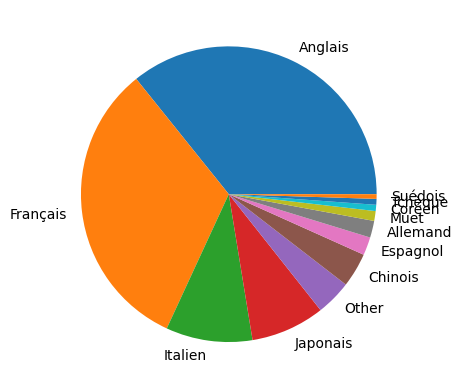

In [43]:
print(df['language'].isna().sum())

nlanguages=31748-1768

language = df[df['language'].notnull()]
language["language"] = language["language"].replace('Cantonais','Chinois')
language["language"] = language["language"].replace('Mandarin','Chinois')

language = language.groupby(['language'])
language = pd.DataFrame({
    'movie': language["movie"],
    "date" : language["date"],
    'nb_screenings':language['movie'].count(),
    'nb_days':language['date'].nunique()
}).reset_index()
language.sort_values(['nb_screenings'], ascending=[False], inplace=True)
language.loc[language['nb_screenings'] < 150, 'language'] = "Other"
language

language = language.groupby(['language'])
language = pd.DataFrame({
    'nb_screenings':language['nb_screenings'].sum(),
}).reset_index()
language.sort_values(['nb_screenings'], ascending=[False], inplace=True)
language

# language = pd.DataFrame({
#     'nb_screenings':language['movie'].count()/nlanguages,
#     'nb_days':language['date'].nunique()
# }).reset_index()
# language.sort_values(['nb_screenings'], ascending=[False], inplace=True)

plt.Figure(figsize=(15,15))
plt.pie(language['nb_screenings'], labels=language["language"])
plt.show() 

In [5]:
# screenings["movie_count"] = screenings.groupby('movie')["movie"].transform('count')
# screenings["movie_count_per_date"] = screenings.groupby('date')["movie"].transform('count')
# screenings
df

,date,showtime,movie,theater,year,weekday,title,directors,duration,language,theater_name,decade
0,2022-01-01,16.000000,les-400-coups-1959,C0074,1959.0,5,Les 400 coups,François Truffaut,6000.0,Français,Reflet Medicis,1950
1,2022-01-04,13.666667,les-400-coups-1959,C0074,1959.0,1,Les 400 coups,François Truffaut,6000.0,Français,Reflet Medicis,1950
2,2022-01-05,17.500000,les-400-coups-1959,C0074,1959.0,2,Les 400 coups,François Truffaut,6000.0,Français,Reflet Medicis,1950
3,2022-01-04,17.833333,louise-l-insoumise-1985,C0074,1985.0,1,Louise... l'insoumise,Charlotte Silvera,NaN,NaN,Reflet Medicis,1980
4,2022-01-11,11.666667,louise-l-insoumise-1985,C0074,1985.0,1,Louise... l'insoumise,Charlotte Silvera,NaN,NaN,Reflet Medicis,1980
...,...,...,...,...,...,...,...,...,...,...,...,...
31743,2022-10-03,20.500000,avatar-2009,C0102,2009.0,0,Avatar,James Cameron,9720.0,Français,UGC Danton,2000
31744,2022-10-04,10.083333,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,Français,UGC Danton,2000
31745,2022-10-04,13.500000,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,Français,UGC Danton,2000
31746,2022-10-04,17.000000,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,Français,UGC Danton,2000


In [6]:
df["directors"].value_counts()

Pier Paolo Pasolini                1139
James Cameron                       967
Kinuyo Tanaka                       688
Wong Kar-Wai                        642
François Truffaut                   566
                                   ... 
Edward Dmytryk                        1
Mantas Kvedaravicius                  1
Dario Argento, George A. Romero       1
Asia Argento                          1
Barbara Hammer                        1
Name: directors, Length: 1526, dtype: int64

In [7]:
director_films = df.groupby(['directors', 'title', 'year'])
director_films = pd.DataFrame({
    'nb_screenings':director_films['movie'].count(),
    'nb_days':director_films['date'].nunique()
}).reset_index()
director_films.sort_values(['nb_screenings', 'directors'], ascending=[False, True], inplace=True)
director_films

,directors,title,year,nb_screenings,nb_days
1448,James Cameron,Avatar,2009.0,959,14
1498,Jean Eustache,La Maman et la Putain,1972.0,532,99
54,Akira Kurosawa,Rashômon,1950.0,420,46
355,Bette Gordon,Variety,1983.0,313,114
1910,"Koji Morimoto, Tensai Okamura, Katsuhiro Ôtomo",Memories,1995.0,264,46
...,...,...,...,...,...
3283,Zelimir Zilnik,Film noir,1971.0,1,1
3284,Zhi Wang,Block 70,2017.0,1,1
3285,Álex de la Iglesia,Le Jour de la bête,1995.0,1,1
3286,Álex de la Iglesia,Perdita Durango,1997.0,1,1


In [8]:
films = films[(films['year']<2018)]
films = df.groupby(['title', 'year'])
films = pd.DataFrame({
    'nb_screenings':films['movie'].count(),
    'nb_days':films['date'].nunique()
}).reset_index()

NameError: name 'films' is not defined

In [9]:
films_recent = films[(films['year']>=2010) & (films['year']<2016)]
films_recent.sort_values(['nb_screenings'], ascending=[False], inplace=True)
films_recent.head(30)

NameError: name 'films' is not defined

In [10]:
films.sort_values(['nb_screenings'], ascending=[False], inplace=True)
films

NameError: name 'films' is not defined

In [11]:
films.sort_values(['nb_days'], ascending=[False], inplace=True)
films

NameError: name 'films' is not defined

In [12]:
decades = df.groupby(['decade'])
decades = pd.DataFrame({
    'nb_screenings':decades['movie'].count(),
    'nb_days':decades['date'].nunique()
}).reset_index()
decades = decades[decades['decade']>"1899"]
decades.sort_values(['decade'], ascending=[True], inplace=True)
decades

,decade,nb_screenings,nb_days
2,1900,10,5
3,1910,60,54
4,1920,432,201
5,1930,745,234
6,1940,1238,288
7,1950,3090,321
8,1960,5475,345
9,1970,4834,341
10,1980,4106,341
11,1990,3712,337


In [17]:
decades = decades[decades['decade']!='2010'].reset_index(drop=True)

<Figure size 640x480 with 0 Axes>

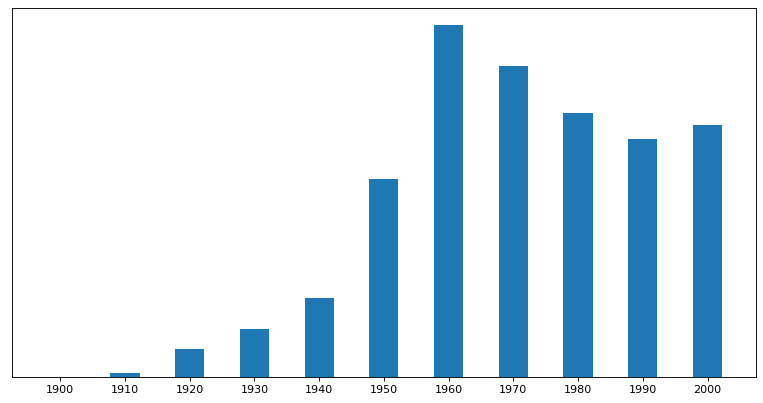

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def plot_decades(decades_played, setxticks=False, cast_int=True):
    plt.clf()
    plt.figure(figsize=(12, 6), dpi=80)
    _ = plt.gca()
    if cast_int:
        plt.bar(decades_played[:,0].astype(int), decades_played[:,1].astype(int), width=4.5)
    else:
        plt.bar(decades_played[:,0], decades_played[:,1].astype(int), width=2.5)
    
    if setxticks:
        _, _ = plt.xticks(decades_played[:,0].astype(int))
        plt.yticks([], [])
    plt.show()

plot_decades(decades.to_numpy(), setxticks=True, cast_int=True)

In [61]:
df['country_graph'] = df['language'].copy()
df.loc[(df['country_graph'].isin(['Français', 'Anglais', 'Italien']))==False, 'country_graph'] = 'Other'

In [63]:
df['count'] = 1

In [67]:
graph = df.groupby(['decade', 'country_graph'])[['count']].sum().reset_index().pivot(index='decade', columns='country_graph', values='count')

In [75]:
graph = graph[(graph.index.astype(int)>1929)&(graph.index.astype(int)<2010)].fillna(0)

In [76]:
graph

country_graph,Anglais,Français,Italien,Other
decade,,,,
1930,348.0,209.0,0.0,188.0
1940,971.0,101.0,18.0,148.0
1950,853.0,534.0,309.0,1394.0
1960,836.0,1395.0,1759.0,1485.0
1970,1954.0,1799.0,513.0,568.0
1980,2329.0,551.0,126.0,1100.0
1990,1937.0,609.0,95.0,1071.0
2000,1969.0,741.0,3.0,1207.0


In [83]:
graph.columns

Index(['Anglais', 'Français', 'Italien', 'Other'], dtype='object', name='country_graph')

In [111]:
def stacked_bar_plot(data, norm=False):
    ind = data.index
    p, x = {}, 0
    for col in data.columns:
        p[x] = data[col]
        x = x+1
    #for x in p.keys():
      #  plt.bar(ind, p[x])
    return(ind, p)

In [107]:
x = graph.sum(axis=1)
for var in graph.columns:
    graph[var] = (graph[var]/x)*100

In [115]:
ind, p = stacked_bar_plot(graph, norm=False)

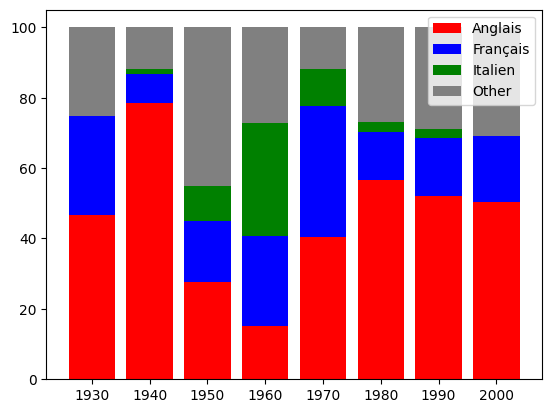

In [116]:
p1 = plt.bar(ind, p[0], label='Anglais', color='r')
p2 = plt.bar(ind, p[1], label='Français', bottom=np.array(p[0]), color='b')
p3 = plt.bar(ind, p[2], label='Italien', bottom=np.array(p[0]+p[1]), color='g')
p4 = plt.bar(ind, p[3], label='Other', bottom=np.array(p[0]+p[1]+p[2]), color='grey')
plt.legend()

In [12]:
#Number of different movies & directors
movie_set = set(list(data2022["movie"].to_numpy()))
director_set = set(list(data2022["director"].to_numpy()))
print(len(data2022), len(movie_set), len(director_set))

33333 3299 1526


In [1]:
### Get one movie per director
movie_per_director = dict()
data_movie_director = data2022[["movie", "director"]]
for index, row in data_movie_director.iterrows():
    dir, mov = row["director"], row["movie"]
    if dir in movie_per_director:
        if mov not in movie_per_director[dir]:
            movie_per_director[dir].append(mov)
    else:
        movie_per_director[dir] = [mov]

for k in sorted(movie_per_director, key=lambda k: len(movie_per_director[k]), reverse=True):
    print(k, len(movie_per_director[k]), movie_per_director[k])


NameError: name 'data2022' is not defined

In [57]:
###Screening on the hours...
data2022_early = data2022.loc[data2022['hour'] < 16]
data2022_afternoon = data2022.loc[(data2022['hour'] >= 16) & (data2022['hour'] <= 20)]
data2022_late = data2022.loc[data2022['hour'] > 20]
print(len(data2022_early)/len(data2022), len(data2022_afternoon)/len(data2022), len(data2022_late)/len(data2022))
counter_movies = Counter(list(data2022["movie"].to_numpy()))
print(counter_movies.most_common(20))
print("####")
print(Counter(list(data2022_early["movie"].to_numpy())).most_common(10))
print(Counter(list(data2022_afternoon["movie"].to_numpy())).most_common(10))
counter_late = Counter(list(data2022_late["movie"].to_numpy()))
for elem in counter_late.most_common(10):
    print(elem, elem[1]/counter_movies[elem[0]])

0.42759427594275945 0.3970239702397024 0.17538175381753818
[('rex-studios-2008', 1587), ('avatar-2009', 959), ('maman-putain-1972', 532), ('rashomon-1950', 420), ('variety-1983', 313), ('memories-1995', 264), ('mamma-roma-1962', 221), ('gerry-2002', 221), ('jour-sans-fin-1993', 219), ('neige-1981', 206), ('lettre-inconnue-1948', 200), ('tears-go-ainsi-vont-larmes-1988', 193), ('salo-120-journees-sodome-1975', 188), ('accattone-1961', 184), ('les-petites-marguerites-1966', 172), ('nos-annees-sauvages-1990', 169), ('the-truman-show-1998', 167), ('infernal-affairs-2002', 160), ('lost-highway-1997', 150), ('edward-mains-argent-1990', 148)]
####
[('rex-studios-2008', 969), ('avatar-2009', 406), ('maman-putain-1972', 263), ('rashomon-1950', 177), ('mamma-roma-1962', 124), ('memories-1995', 108), ('tears-go-ainsi-vont-larmes-1988', 99), ('variety-1983', 92), ('lettre-inconnue-1948', 89), ('accattone-1961', 86)]
[('rex-studios-2008', 618), ('avatar-2009', 284), ('maman-putain-1972', 240), ('ra